# XGBoost 기반 소비 예측 모델링

## 1. 문제 정의
---
### 우리는 돈을 왜 모으지 못하는가 ?
소비자는 일상적인 소비 활동 과정에서 충동 소비나 예산 초과와 같은 문제를
반복적으로 경험하고, 이러한 소비 행태가 저축률 감소로 이어지고 있음을 인지하지
못하는 경우가 많다.

기존 금융 분석 및 가계부 서비스는 예산 초과나 이상 소비 발생 이후에 사후 알림을 제공하는
한계를 가진다.

## 2. 분석 목표
---
사용자의 과거 소비 데이터를 기반으로 특정 기간의 지출 금액을 예측하고, 예측 결과를 통해 소비 패턴 분석을 검증하기 위해 진행한다.

또한 미래의 소비를 사전에 인지하여 합리적인 소비 계획을 할 수 있도록 지원하는 것을 목적으로 XGBoost 기반 소비 예측 모델링을 구축하려한다.

# 3. 데이터셋



---



## 3.1 데이터 수집 및 구성

120,000개의 가상 마이데이터가 사전에 정의된 5가지 소비 유형(절약형, 안정형, 목표요정형, YOLO형, 진격의 투자형)으로 나눠 생성되어있다.

그 중 단일 사용자 (user_id = 132) 에 대한 가상 마이데이터는 약 1900건이다.


## 3.2 주요 컬럼 구성

SELECT category, spend_date, price, transaction_type

FROM spending

where user_id = 132


# 4. 사전 세팅



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip -q install -U xgboost


In [3]:
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier, XGBRegressor


df = pd.read_csv("/content/drive/MyDrive/Moni project - 소비 행동 패턴 기반 나만의 AI 금융 코치 /132.csv", encoding="cp949")

In [4]:
df.head(10)

,user_id,category,spend_date,price,transaction_type
0,132,etc,2023-12-31 15:00,83475539,입금
1,132,living,2024-01-01 1:30,144300,출금
2,132,coffee,2024-01-01 7:08,26200,출금
3,132,entertainment,2024-01-01 11:07,31900,출금
4,132,entertainment,2024-01-01 11:44,106600,출금
5,132,entertainment,2024-01-01 12:09,101200,출금
6,132,shopping,2024-01-02 1:36,146100,출금
7,132,transport,2024-01-02 5:01,116700,출금
8,132,entertainment,2024-01-02 5:28,265000,출금
9,132,transport,2024-01-02 6:09,206900,출금


In [5]:
df['transaction_type'].value_counts()

,count
transaction_type,
출금,1852
입금,25


# 5. 데이터 전처리


In [6]:
# spend_date 컬럼이 UTC 기준임 → KST(+9) 변환
df["spend_date"] = (
    pd.to_datetime(df["spend_date"], utc=True)
      .dt.tz_convert("Asia/Seoul")
      .dt.tz_localize(None)
)

print("==spend_date==")
print(df["spend_date"].head())

# 출금 데이터 필터링
df = df[df["transaction_type"] == "출금"].copy()

print("\n==transaction_type==")
print(df["transaction_type"].value_counts())

# 시간대별 소비 패턴 반영위해 시간 파생 변수 생성(hour, weekday(0~6), is_weekend(0/1))
df["hour"] = df["spend_date"].dt.hour
df["weekday"] = df["spend_date"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

print("\n==time feature==")
print(df[["spend_date", "hour", "weekday", "is_weekend"]].head(10))


==spend_date==
0   2024-01-01 00:00:00
1   2024-01-01 10:30:00
2   2024-01-01 16:08:00
3   2024-01-01 20:07:00
4   2024-01-01 20:44:00
Name: spend_date, dtype: datetime64[ns]

==transaction_type==
transaction_type
출금    1852
Name: count, dtype: int64

==time feature==
            spend_date  hour  weekday  is_weekend
1  2024-01-01 10:30:00    10        0           0
2  2024-01-01 16:08:00    16        0           0
3  2024-01-01 20:07:00    20        0           0
4  2024-01-01 20:44:00    20        0           0
5  2024-01-01 21:09:00    21        0           0
6  2024-01-02 10:36:00    10        1           0
7  2024-01-02 14:01:00    14        1           0
8  2024-01-02 14:28:00    14        1           0
9  2024-01-02 15:09:00    15        1           0
10 2024-01-02 18:26:00    18        1           0


In [7]:
# 예측 안정성을 위해 Weekly feature
spend = df.copy()
spend["week"] = spend["spend_date"].dt.isocalendar().week.astype(int)
spend["month"] = spend["spend_date"].dt.month.astype(int)

print("==spend 상위 5개==")
print(spend[["spend_date", "week", "month"]].head())


==spend 상위 5개==
           spend_date  week  month
1 2024-01-01 10:30:00     1      1
2 2024-01-01 16:08:00     1      1
3 2024-01-01 20:07:00     1      1
4 2024-01-01 20:44:00     1      1
5 2024-01-01 21:09:00     1      1


In [8]:
# 예측 안정성을 위해 주차 x 카테고리
weekly_cat = (
    spend
    .groupby(["week", "month", "category"], as_index=False)
    .agg(
        total_spend=("price", "sum"),    # 해당 주, 카테고리 총 지출
        spend_count=("price", "count"),      # 해당 주, 카테고리 거래 횟수
        weekend_ratio=("is_weekend", "mean"),     # 주말 지출 비중(0~1)
    )
)

print("\n==weekly_cat 상위 10개==")
print(weekly_cat.head(10))



==weekly_cat 상위 10개==
   week  month       category  total_spend  spend_count  weekend_ratio
0     1      1         beauty       107800            1       0.000000
1     1      1         coffee        92600            8       0.375000
2     1      1  entertainment       642700            6       0.166667
3     1      1           food       337400           10       0.800000
4     1      1         health       248400            4       0.500000
5     1      1         living       251600            2       0.500000
6     1      1       shopping       658000            5       0.200000
7     1      1      transport       555200            6       0.500000
8     1     12         coffee         8400            1       0.000000
9     1     12  entertainment       242800            2       0.000000


# 6. 결측치 처리

Raw 거래 데이터 → 주차 집계 → 과거 패턴 생성 → 미래 예측 구조로 변환

spending 데이터에서 소비가 발생하지 않은 주차의 누락데이터를 방지하기 위해 week × category Full Grid를 구성하여 결측치가 아닌 소비없음 (0)으로 처리하였다.

반면, 과거 값이 없어서 계산이 불가능한 Lag 및 Rolling Feature 생성 과정에서 발생한 결측치는 시계열 특성에 따른 자연스러운 현상으로 구분하였다.

In [9]:
# 소비가 없는 주차 Full Grid (week × category 조합 생성)하여 소비 0으로 변환
weeks = sorted(weekly_cat["week"].unique())
cats = sorted(weekly_cat["category"].unique())

grid = (
    pd.MultiIndex.from_product([weeks, cats], names=["week", "category"])
    .to_frame(index=False)
)

# month 정보는 week마다 하나로 붙여야 해서, week→대표 month 매핑
week_to_month = (
    spend.groupby("week")["month"].agg(lambda s: int(s.mode().iloc[0])).to_dict()
)
grid["month"] = grid["week"].map(week_to_month)

weekly_cat = grid.merge(weekly_cat, on=["week", "month", "category"], how="left")

weekly_cat["total_spend"] = weekly_cat["total_spend"].fillna(0)
weekly_cat["spend_count"] = weekly_cat["spend_count"].fillna(0)
weekly_cat["weekend_ratio"] = weekly_cat["weekend_ratio"].fillna(0)

In [10]:
weekly_cat[weekly_cat["total_spend"] == 0]

,week,category,month,total_spend,spend_count,weekend_ratio
3,1,etc,1,0.0,0.0,0.0
6,1,investment,1,0.0,0.0,0.0
8,1,savemoney,1,0.0,0.0,0.0
14,2,etc,1,0.0,0.0,0.0
17,2,investment,1,0.0,0.0,0.0
...,...,...,...,...,...,...
553,51,etc,12,0.0,0.0,0.0
556,51,investment,12,0.0,0.0,0.0
557,51,living,12,0.0,0.0,0.0
558,51,savemoney,12,0.0,0.0,0.0


In [11]:
# 전체기간 중 소비가 거의 없는 불필요한 category 노이즈 제거
active_cats = (
    weekly_cat.groupby("category")["total_spend"]
    .sum()
    .loc[lambda x: x > 0]
    .index
)

weekly_cat = weekly_cat[weekly_cat["category"].isin(active_cats)]

print("전체 category 수:", weekly_cat["category"].nunique())

print("\n활성 category 목록:")
print(list(active_cats))

print("\n카테고리별 총 지출:")
print(
    weekly_cat.groupby("category")["total_spend"].sum()
)

전체 category 수: 11

활성 category 목록:
['beauty', 'coffee', 'entertainment', 'etc', 'food', 'health', 'investment', 'living', 'savemoney', 'shopping', 'transport']

카테고리별 총 지출:
category
beauty            3223200.0
coffee            2426700.0
entertainment    18727553.0
etc               2116300.0
food             17066500.0
health           28564100.0
investment       23352000.0
living            8714900.0
savemoney        38064000.0
shopping         34977990.0
transport        14906400.0
Name: total_spend, dtype: float64


In [12]:
# 소비가 있었는지 여부(0/1)
weekly_cat["has_spend"] = (weekly_cat["total_spend"] > 0).astype(int)

print(weekly_cat[["total_spend", "has_spend"]].head())

print("\n개수:")
print(weekly_cat["has_spend"].value_counts())

   total_spend  has_spend
0     107800.0          1
1      92600.0          1
2     642700.0          1
3          0.0          0
4     337400.0          1

개수:
has_spend
1    404
0    168
Name: count, dtype: int64


In [13]:
#  Lag / Rolling features

#lag_1 - 1주 전 지출
#lag_2 - 2주 전 지출
#roll_mean_2	- 최근 2주 평균
#roll_mean_4	- 최근 4주 평균
#roll_std_4	- 최근 4주 변동성
#roll_mean_2	- 최근 2주 평균

weekly_cat = weekly_cat.sort_values(["category", "week"]).reset_index(drop=True)

weekly_cat["lag_1"] = weekly_cat.groupby("category")["total_spend"].shift(1)
weekly_cat["lag_2"] = weekly_cat.groupby("category")["total_spend"].shift(2)

weekly_cat["roll_mean_2"] = (
    weekly_cat.groupby("category")["total_spend"]
    .shift(1)
    .rolling(2)
    .mean()
    .reset_index(level=0, drop=True)
)

weekly_cat["roll_mean_4"] = (
    weekly_cat.groupby("category")["total_spend"]
    .shift(1)
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

weekly_cat["roll_std_4"] = (
    weekly_cat.groupby("category")["total_spend"]
    .shift(1)
    .rolling(4)
    .std()
    .reset_index(level=0, drop=True)
)
# 결측 제거
weekly_cat = weekly_cat.dropna().reset_index(drop=True)

# category dtype
weekly_cat["category"] = weekly_cat["category"].astype("category")

print(
    weekly_cat[
        ["category", "week", "total_spend",
         "lag_1", "lag_2",
         "roll_mean_2", "roll_mean_4"]
    ].head(10)
)

print("결측 개수:")
print(weekly_cat.isna().sum())

  category  week  total_spend     lag_1     lag_2  roll_mean_2  roll_mean_4
0   beauty     5      79800.0  104500.0  175300.0     139900.0     136850.0
1   beauty     6     196500.0   79800.0  104500.0      92150.0     129850.0
2   beauty     7          0.0  196500.0   79800.0     138150.0     139025.0
3   beauty     8          0.0       0.0  196500.0      98250.0      95200.0
4   beauty     9      73800.0       0.0       0.0          0.0      69075.0
5   beauty    10     132100.0   73800.0       0.0      36900.0      67575.0
6   beauty    11     203800.0  132100.0   73800.0     102950.0      51475.0
7   beauty    12          0.0  203800.0  132100.0     167950.0     102425.0
8   beauty    13     215800.0       0.0  203800.0     101900.0     102425.0
9   beauty    14          0.0  215800.0       0.0     107900.0     137925.0
결측 개수:
week             0
category         0
month            0
total_spend      0
spend_count      0
weekend_ratio    0
has_spend        0
lag_1            0
lag_2

In [14]:
#  Time-based split (train wide, valid 1w, test 1w)
weeks2 = sorted(weekly_cat["week"].unique())
valid_weeks = weeks2[-2:-1]
test_weeks  = weeks2[-1:]
train_weeks = weeks2[:-2]

train = weekly_cat[weekly_cat["week"].isin(train_weeks)].copy()
valid = weekly_cat[weekly_cat["week"].isin(valid_weeks)].copy()
test  = weekly_cat[weekly_cat["week"].isin(test_weeks)].copy()


In [15]:
# 데이터터입 보정
for d in [train, valid, test]:
    d["category"] = d["category"].astype("category")

features = [
    "month", "category",
    "spend_count", "weekend_ratio",
    "lag_1", "lag_2",
    "roll_mean_2", "roll_mean_4", "roll_std_4"
]
target = "total_spend"


In [16]:
import numpy as np

# X_train, X_valid 피처 추출
X_train = train[features].copy()
X_valid = valid[features].copy()

# category One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=["category"], drop_first=False)
X_valid = pd.get_dummies(X_valid, columns=["category"], drop_first=False)

# train 기준으로 valid 컬럼 정렬 (feature 불일치 방지)
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

# bool 타입 → int 변환
bool_cols = X_train.select_dtypes(include="bool").columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_valid[bool_cols] = X_valid[bool_cols].astype(int)

# 타겟 로그 변환
y_train_reg = np.log1p(train[target].values)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train_reg shape:", y_train_reg.shape)

X_train shape: (506, 19)
X_valid shape: (11, 19)
y_train_reg shape: (506,)


# 7. 이상치

user_id = 132의 이상치는 주로 investment, savemoney, healty 카테고리에서 관측되었으며, 비정기적 고액 소비 이벤트로 판단하였다.

해당 이상치는 제거하지 않고, 이상 소비 발생 시 사용자에게 알림 제공으로 활용하였다.

In [17]:
def detect_upper_outliers(df, value_col):
    Q1 = df[value_col].quantile(0.25)
    Q3 = df[value_col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return df[df[value_col] > upper_bound]

outliers_by_cat = (
    weekly_cat
    .groupby("category", group_keys=False)
    .apply(detect_upper_outliers, value_col="total_spend")
)

print(
    outliers_by_cat["category"].value_counts()
)

category
investment       12
savemoney        12
health            9
etc               9
transport         5
food              4
entertainment     2
living            2
beauty            0
coffee            0
shopping          0
Name: count, dtype: int64


/tmp/ipython-input-288/8735632.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("category", group_keys=False)
/tmp/ipython-input-288/8735632.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_upper_outliers, value_col="total_spend")


<Figure size 1000x600 with 0 Axes>

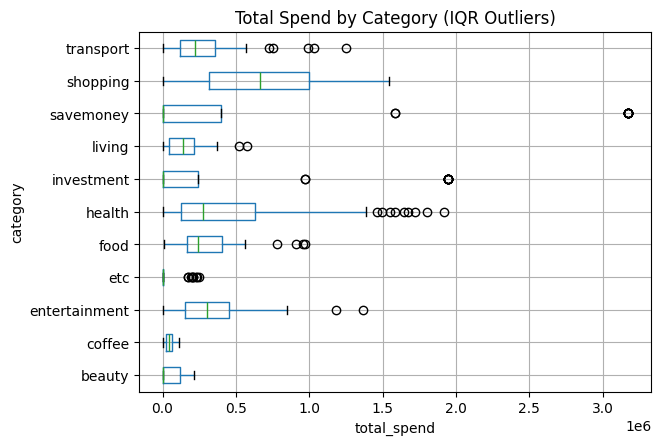

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
weekly_cat.boxplot(
    column="total_spend",
    by="category",
    vert=False
)
plt.title("Total Spend by Category (IQR Outliers)")
plt.suptitle("")
plt.xlabel("total_spend")
plt.show()


# 9. XGBoost
### XGBoost 선택 이유

- 소비 데이터는 규칙이 단순하지 않고 변동성이 커 비선형 패턴이 강하게 나타나므로, 과거 소비 흐름을 반영하고 예측 근거를 설명할 수 있는 GBDT 계열 모델을 선정하였다.
    
    또한, Level-wise 방식은 트리를 확장하여, 동일한 깊이의 노드를 균형 있게 분할한다. 이로 인해 소규모 데이터 환경에서도 특정 패턴에 과도하게 치우치는 학습을 줄이고, 예측 결과의 분산이 비교적 작아 안정적인 예측이 가능하다.
    
    따라서, 비선형·변동성 높은 소비 데이터를 안정적으로 학습하고, 소규모 데이터에서도 예측이 덜 튀는 구조로 알림 목적에 적합한 XGBoost를 선택하였다.
    
### 사용모델

- XGBoost Classifier
- XGBoost Regressor

### 모델 설계 및 선택 이유

- 소비없음 (0)이 다수 존재하여 단일 회귀 모델로는 0값에 과도하게 끌려감.
- 실제 소비 금액 예측이 불안정할 위험이 존재함.
- 따라서, 소비 발생여부와 소비 금액을 분리한 2단계 모델 구조 선택.

## 9.1 XGBoost Regressor

정기적 소비 패턴이 존재하는 카테고리에서 예측 성능이 양호했지만, 과소비 지출의 영향으로 과대 예측 발생했다.

In [20]:
reg = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mae",
)
reg.fit(X_train, y_train_reg, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

### 9.1.1 검증 데이터 예측

In [21]:
pred_amount = np.expm1(reg.predict(X_valid))
pred_amount = np.maximum(0, pred_amount)  # 금액 음수 방지

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_valid_true = valid[target].values

mae = mean_absolute_error(y_valid_true, pred_amount)
rmse = np.sqrt(mean_squared_error(y_valid_true, pred_amount))

print("MAE :", mae)
print("RMSE:", rmse)

compare = pd.DataFrame({"actual": y_valid_true, "pred": pred_amount})
print(compare.head(10))

MAE : 54317.54054428041
RMSE: 90606.63348617547
     actual           pred
0       0.0       0.000000
1   24500.0   19784.335938
2   31300.0   69511.539062
3       0.0       0.001427
4   40800.0  116271.351562
5   91800.0  279162.718750
6       0.0       0.000000
7       0.0       1.389872
8       0.0       0.000000
9  386690.0  480263.500000


## 9.2 XGBClassifier

소비 발생 여부에 대한 분류 모델은 안정적인 예측 성능을 보였다.

In [23]:
y_train_cls = (train.iloc[:X_train.shape[0]][target].values > 0).astype(int)

cls = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

cls.fit(X_train, y_train_cls, verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

### 9.2.1 검증 데이터 예측

In [26]:
pred_prob = cls.predict_proba(X_valid)[:, 1]  # 클래스 1(소비 발생)의 확률

print("pred_prob shape:", pred_prob.shape)
print("pred_prob sample:", pred_prob[:5])

pred_prob shape: (11,)
pred_prob sample: [0.00811453 0.99765116 0.99793136 0.00632329 0.9954561 ]


## 9.3 최종

In [25]:
# week_start 컬럼 생성 (주차 시작일)
valid_copy = valid.copy()
valid_copy["week_start"] = pd.to_datetime("2024-01-01") + pd.to_timedelta((valid_copy["week"] - 1) * 7, unit="D")
valid_copy["week_start"] = valid_copy["week_start"] - pd.to_timedelta(valid_copy["week_start"].dt.dayofweek, unit="D")
valid_copy["week_start"] = valid_copy["week_start"].dt.strftime("%Y-%m-%d")

df_result = valid_copy[["week_start", "week", "month", "category"]].copy()

# 실제 지출
df_result["actual_spend"] = valid[target].values


# 기대 지출 = 확률 × 예측 금액
df_result["expected_spend"] = pred_prob * pred_amount

# 소비 발생 여부 (0/1)
THRESHOLD = 0.5
df_result["pred_spend_flag"] = (pred_prob >= THRESHOLD).astype(int)

# 오차율 (%)
df_result["pct_diff"] = np.where(
    df_result["actual_spend"] > 0,
    (df_result["actual_spend"] - df_result["expected_spend"])
    / df_result["actual_spend"] * 100,
    np.nan
)

# 기대지출 기준 정렬
df_result = (
    df_result
    .sort_values("expected_spend", ascending=False)
    .reset_index(drop=True)
)

df_result.head(30)

,week_start,week,month,category,actual_spend,expected_spend,pred_spend_flag,pct_diff
0,2024-12-16,51,12,shopping,386690.0,479154.750000,1,-23.911854
1,2024-12-16,51,12,transport,247100.0,443902.906250,1,-79.645045
2,2024-12-16,51,12,health,91800.0,277944.468750,1,-202.771752
3,2024-12-16,51,12,food,40800.0,115743.023438,1,-183.683881
4,2024-12-16,51,12,entertainment,31300.0,69367.742188,1,-121.622180
5,2024-12-16,51,12,coffee,24500.0,19737.865234,1,19.437285
6,2024-12-16,51,12,living,0.0,0.024005,0,NaN
7,2024-12-16,51,12,etc,0.0,0.000009,0,NaN
8,2024-12-16,51,12,beauty,0.0,0.000000,0,NaN
9,2024-12-16,51,12,investment,0.0,0.000000,0,NaN


## 10. 회고

- 가상 데이터 기반으로 생성된 약 1년간의 지출 내역을 활용하여 분석을 진행하였다. 단일 사용자 데이터만을 사용했기 때문에 학습 데이터량이 제한적이었고, 이로 인해 소비 패턴의 일반화에는 구조적인 한계가 존재했다.

- 분석 결과, 정기적인 소비 패턴이 뚜렷한 카테고리에서는 비교적 안정적인 예측 성능을 보였지만, 비정기적 과소비 카테고리에서는 과거 고액 지출의 영향으로 예측 금액이 실제보다 과대 추정되는 현상이 발생했다.

- 따라서, 금액 예측 중심의 알림보다는 XGBoost Classifier 기반의 소비 발생 예측을 활용한 알림 구조가 더 적합하다고 판단하였다.
